# Importing libraries and functions
            
Importing required libraries

In [2]:
# Importing required libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Softmax, Multiply, Lambda, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
import os
import sys



In [3]:
def make_dir(path): # Function to make adirectory to save files in
    cwd = os.getcwd()
    abs_path = cwd + path



    if not os.path.exists(abs_path):
        try: 
            os.makedirs(abs_path)
            print(abs_path)
        except OSError:return 0
        else: return 1
    else: return 2

In [4]:
def get_APE(pred,y_true):# Function to return an array with APE of each prediction 
    APE = np.zeros(y_true.shape[0])
    for i in range(y_true.shape[0]):
        APE[i] = abs((pred[i] - y_true[i]) / y_true[i])

    return APE

def get_max_APE(APE): # Function to return the maximum APE with index value
    max_APE = np.zeros(2)

    for i in range(40, 160):
        if APE[i] > max_APE[0]:
            max_APE[0] = APE[i]
            max_APE[1] = i
    return max_APE

In [5]:
# Declaring Variables
num_epochs = 2000000

# Filepaths for saving Model Checkpoints:
save_post_dir = '/mnt/IMP/Work/Thesis/NeuralNetwork/DeepLearning-RarefiedFlows/PostProc/MaNumber/HyperBand/Adam-Retrained/'

In [6]:
# Reading data from .csv file
data_dat = pd.read_csv (r'data.csv')
pred_dat = pd.read_csv (r'test.csv')

In [17]:
# Extracting data into numpy arrays from pandas DataFrames

# Training data
X = pd.DataFrame(data_dat, columns = ['XL', 'LD'])
X = X.to_numpy()

y = pd.DataFrame(data_dat, columns = ['Ma'])
y = y.to_numpy()

# Prediction data
X_pred = pd.DataFrame(pred_dat, columns = ['XL', 'LD'])
X_pred = X_pred.to_numpy()
X_pred_ns = X_pred

y_pred = pd.DataFrame(pred_dat, columns = ['Ma'])
y_pred = y_pred.to_numpy()



In [18]:
# Returns normalised valeus of Mach Number and Maximum Mach Number per L/D ratio as two arrays

def get_norm_y(y,c): 
    num = y.shape[0]//c
    y_norm = np.zeros([num*c,2])
    for i in range(num):
        max_val = max(y[i*c:(i+1)*c])
        y_norm[i*c:(i+1)*c,1] = max_val 
        y_norm[i*c:(i+1)*c,0] = y[i*c:(i+1)*c,0]/max_val
    return y_norm
    
y_norm = get_norm_y(y, 201)
y_pred_norm = get_norm_y(y_pred, 201)


In [148]:
hl = 14
units_max_val = 7
units_ind_val = 22

def get_LD(x): # Function to separate L/D Ratio for the Lambda Layer.
    x_new = x[:,1]
    return x_new[:,np.newaxis]

# Define a function to build a SN
def build_model(hl, units_max_val, units_ind_val):
    Input_layer = Input(shape=[2,], name='Input')
    # Lambda layer to separately use it as only L/D ratio input for a fork in Network.
    MaxVal_input = Lambda(get_LD, name='MaxVal_input', output_shape=(1,))(Input_layer)
    # Defining the MaxVal fork of SN    
    MaxVal_layer = []
    IndVal_layer = []
    for i in range(hl):
        if i==0: # First layer in MaxVal fork
            IndVal_layer.append(Dense(units_ind_val, name='IndVal_layer%d' %(i+1), activation='relu')(Input_layer))
            MaxVal_layer.append(Dense(units_max_val, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_input))
        elif i==hl-1: # Last layer in MaxVal fork. *Activation must be linear*
            IndVal_layer.append(Dense(1, name='IndVal_Final_layer', activation='linear')(IndVal_layer[i-1]))
            MaxVal_layer.append(Dense(1, name='MaxVal_Final_layer', activation='linear')(MaxVal_layer[i-1]))
        else: # For intermediate layers
            IndVal_layer.append(Dense(units_ind_val, name='IndVal_layer%d' %(i+1), activation='relu')(IndVal_layer[i-1]))
            MaxVal_layer.append(Dense(units_max_val, name='MaxVal_layer%d' %(i+1), activation='relu')(MaxVal_layer[i-1]))
    # Building the model with all connections            
    model = Model(inputs= [Input_layer], outputs= [IndVal_layer[-1], MaxVal_layer[-1]])
    return model

model = build_model(hl, units_max_val, units_ind_val)

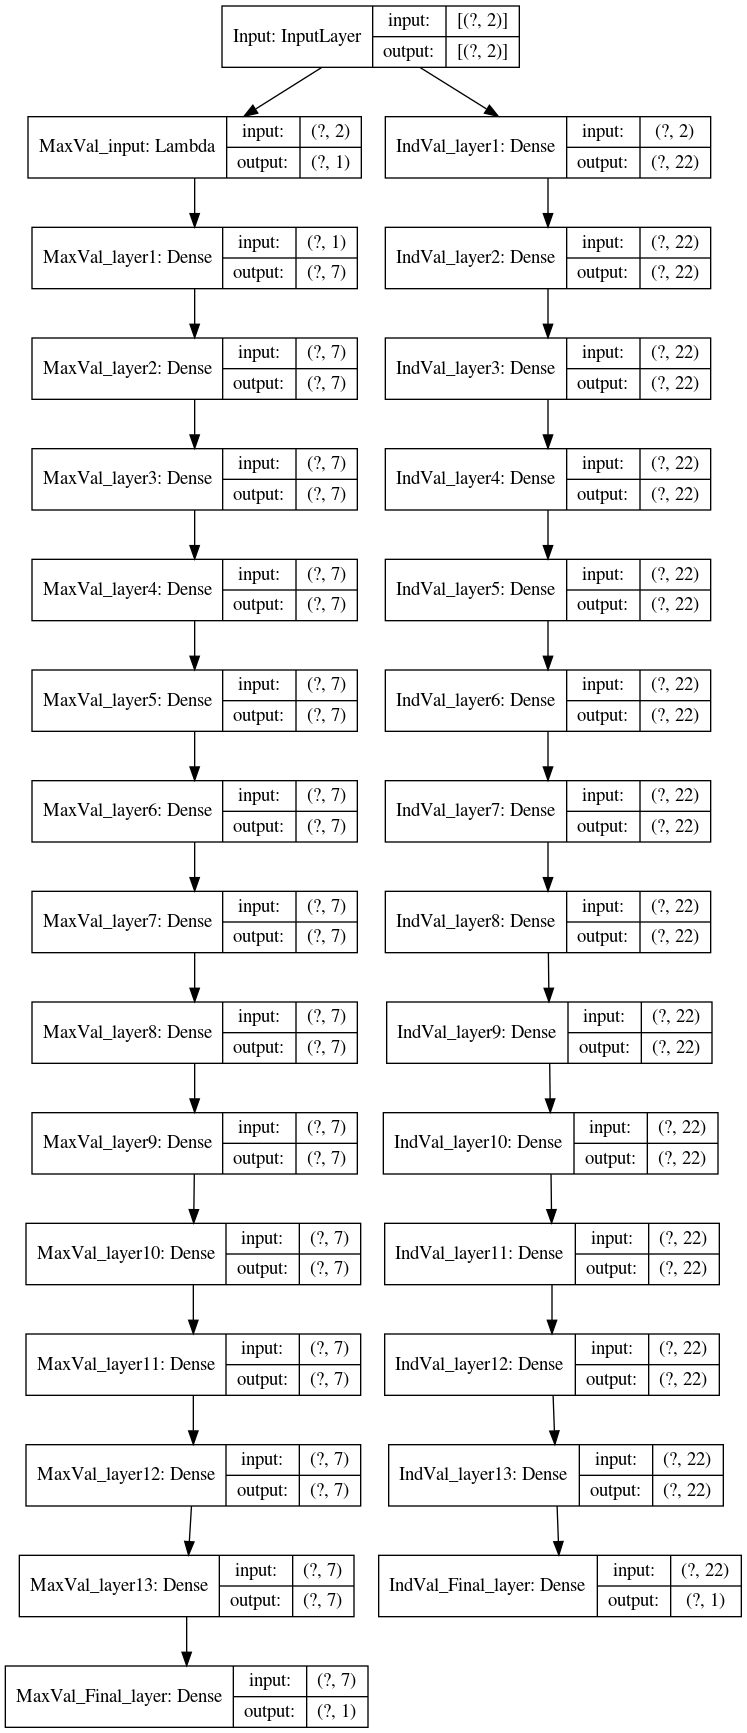

In [65]:
# A visual flowchart of the model.
keras.utils.plot_model(model, "/mnt/IMP/Work/Thesis/NeuralNetwork/DeepLearning-RarefiedFlows/PostProc/MaNumber/HyperBand/Adam-Retrained/Adam-HPT-Ma.png", show_shapes=True)

In [149]:
Adam = tf.keras.optimizers.Adam(
    learning_rate=0.0005,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
)
model.compile(loss='mse', optimizer=Adam, metrics=['mape'])

In [150]:
early_stopping_callback = EarlyStopping(monitor='val_IndVal_Final_layer_mape', 
                                        patience=400,
                                        min_delta= 1e-4,
                                        restore_best_weights=True,
                                        mode='min',
                                        verbose=True)

In [151]:
##### Using sklearn to split the data into train and test sets with shuffling ####
X_train, X_test, y_train_comb, y_test_comb = train_test_split(X, y_norm, test_size=0.2, random_state=42, shuffle=True)

In [152]:
history = model.fit(X_train,
                    (y_train_comb[:,0],y_train_comb[:,1]),
                    batch_size = 2,
                    epochs = 20000000000000,
                    verbose=1,
                    validation_data=(X_test, (y_test_comb[:,0],y_test_comb[:,1])),
                    callbacks=[early_stopping_callback])
model.save('/mnt/IMP/Work/Thesis/NeuralNetwork/DeepLearning-RarefiedFlows/SavedModels/MaNumber/HyperBand/model_Adam_Retrained')

Train on 482 samples, validate on 121 samples
Epoch 1/20000000000000
482/482 [==============================] - 3s 7ms/sample - loss: 5.0981 - IndVal_Final_layer_loss: 0.1737 - MaxVal_Final_layer_loss: 4.9244 - IndVal_Final_layer_mape: 170.6257 - MaxVal_Final_layer_mape: 65.2130 - val_loss: 0.3487 - val_IndVal_Final_layer_loss: 0.1098 - val_MaxVal_Final_layer_loss: 0.2361 - val_IndVal_Final_layer_mape: 208.0717 - val_MaxVal_Final_layer_mape: 19.6829
Epoch 2/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.3572 - IndVal_Final_layer_loss: 0.1128 - MaxVal_Final_layer_loss: 0.2443 - IndVal_Final_layer_mape: 184.0985 - MaxVal_Final_layer_mape: 20.3205 - val_loss: 0.3301 - val_IndVal_Final_layer_loss: 0.1153 - val_MaxVal_Final_layer_loss: 0.2124 - val_IndVal_Final_layer_mape: 235.7862 - val_MaxVal_Final_layer_mape: 18.8352
Epoch 3/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.3156 - IndVal_Final_layer_loss: 0.1109 - MaxVal_

Epoch 21/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0024 - IndVal_Final_layer_loss: 0.0024 - MaxVal_Final_layer_loss: 5.3592e-06 - IndVal_Final_layer_mape: 15.4168 - MaxVal_Final_layer_mape: 0.0616 - val_loss: 0.0016 - val_IndVal_Final_layer_loss: 0.0016 - val_MaxVal_Final_layer_loss: 2.4523e-06 - val_IndVal_Final_layer_mape: 18.5880 - val_MaxVal_Final_layer_mape: 0.0400
Epoch 22/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0052 - IndVal_Final_layer_loss: 0.0052 - MaxVal_Final_layer_loss: 1.5199e-06 - IndVal_Final_layer_mape: 23.4353 - MaxVal_Final_layer_mape: 0.0340 - val_loss: 0.0015 - val_IndVal_Final_layer_loss: 0.0015 - val_MaxVal_Final_layer_loss: 6.8720e-07 - val_IndVal_Final_layer_mape: 20.8441 - val_MaxVal_Final_layer_mape: 0.0329
Epoch 23/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0015 - IndVal_Final_layer_loss: 0.0015 - MaxVal_Final_layer_loss: 3.7577e-07 - IndV

482/482 [==============================] - 1s 3ms/sample - loss: 0.0035 - IndVal_Final_layer_loss: 0.0035 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 17.6335 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0079 - val_IndVal_Final_layer_loss: 0.0079 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 42.4158 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 41/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 0.0032 - IndVal_Final_layer_loss: 0.0032 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 22.9332 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.5822e-04 - val_IndVal_Final_layer_loss: 8.6305e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 14.8213 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 42/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0021 - IndVal_Final_layer_loss: 0.0021 - MaxVal_Final_layer_loss: 0.0000e+00 - IndV

482/482 [==============================] - 1s 3ms/sample - loss: 0.0028 - IndVal_Final_layer_loss: 0.0028 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 15.9787 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0106 - val_IndVal_Final_layer_loss: 0.0106 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 56.8654 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 60/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0028 - IndVal_Final_layer_loss: 0.0028 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 19.2548 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0035 - val_IndVal_Final_layer_loss: 0.0035 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 18.1216 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 61/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0037 - IndVal_Final_layer_loss: 0.0037 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final

482/482 [==============================] - 1s 3ms/sample - loss: 0.0014 - IndVal_Final_layer_loss: 0.0014 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 10.6988 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0016 - val_IndVal_Final_layer_loss: 0.0016 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 22.9828 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 79/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 0.0013 - IndVal_Final_layer_loss: 0.0013 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 11.7151 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.9346e-04 - val_IndVal_Final_layer_loss: 6.9045e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 11.6291 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 80/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0013 - IndVal_Final_layer_loss: 0.0013 - MaxVal_Final_layer_loss: 0.0000e+00 - IndV

482/482 [==============================] - 1s 3ms/sample - loss: 0.0012 - IndVal_Final_layer_loss: 0.0012 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 10.5747 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0046 - val_IndVal_Final_layer_loss: 0.0046 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 35.6753 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 98/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0035 - IndVal_Final_layer_loss: 0.0035 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 19.1672 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0035 - val_IndVal_Final_layer_loss: 0.0036 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 12.3020 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 99/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0015 - IndVal_Final_layer_loss: 0.0015 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final

482/482 [==============================] - 1s 3ms/sample - loss: 7.4778e-04 - IndVal_Final_layer_loss: 7.4778e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.5559 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0036 - val_IndVal_Final_layer_loss: 0.0036 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 29.0770 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 117/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0019 - IndVal_Final_layer_loss: 0.0019 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 14.4481 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0030 - val_IndVal_Final_layer_loss: 0.0030 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 18.6801 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 118/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 0.0019 - IndVal_Final_layer_loss: 0.0019 - MaxVal_Final_layer_loss: 0.0000e+00 - Ind

482/482 [==============================] - 2s 3ms/sample - loss: 4.5720e-04 - IndVal_Final_layer_loss: 4.5720e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.8098 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.4194e-04 - val_IndVal_Final_layer_loss: 4.4537e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.3846 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 136/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.6440e-04 - IndVal_Final_layer_loss: 4.6440e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.9080 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0025 - val_IndVal_Final_layer_loss: 0.0025 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 14.1416 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 137/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 5.9345e-04 - IndVal_Final_layer_loss: 5.9345e-04 - MaxVal_Final_layer_

482/482 [==============================] - 1s 3ms/sample - loss: 0.0013 - IndVal_Final_layer_loss: 0.0013 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 10.0978 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0019 - val_IndVal_Final_layer_loss: 0.0019 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 13.5614 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 155/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 8.8514e-04 - IndVal_Final_layer_loss: 8.8514e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.4542 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.7293e-04 - val_IndVal_Final_layer_loss: 4.7011e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 11.9490 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 156/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.2068e-04 - IndVal_Final_layer_loss: 4.2068e-04 - MaxVal_Final_layer_loss: 

482/482 [==============================] - 2s 4ms/sample - loss: 0.0023 - IndVal_Final_layer_loss: 0.0023 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 13.0202 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0014 - val_IndVal_Final_layer_loss: 0.0014 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 23.3103 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 174/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 6.3579e-04 - IndVal_Final_layer_loss: 6.3579e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 9.9594 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.0930e-04 - val_IndVal_Final_layer_loss: 3.0758e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.0978 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 175/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 0.0028 - IndVal_Final_layer_loss: 0.0028 - MaxVal_Final_layer_loss: 0.0000e+0

482/482 [==============================] - 1s 3ms/sample - loss: 7.5474e-04 - IndVal_Final_layer_loss: 7.5474e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.0039 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.2439e-04 - val_IndVal_Final_layer_loss: 1.2372e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.8482 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 193/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.1258e-04 - IndVal_Final_layer_loss: 4.1258e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.2450 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.9903e-04 - val_IndVal_Final_layer_loss: 4.0644e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.0928 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 194/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 2.7487e-04 - IndVal_Final_layer_loss: 2.7487e-04 - MaxVal_Final

Epoch 211/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.5907e-04 - IndVal_Final_layer_loss: 8.5907e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.2554 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0017 - val_IndVal_Final_layer_loss: 0.0017 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 16.5473 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 212/20000000000000
482/482 [==============================] - 3s 5ms/sample - loss: 4.4761e-04 - IndVal_Final_layer_loss: 4.4761e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.4875 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0018 - val_IndVal_Final_layer_loss: 0.0018 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 23.9760 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 213/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0011 - IndVal_Final_layer_loss: 0.0011 - MaxVal_Fi

Epoch 230/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 8.2893e-04 - IndVal_Final_layer_loss: 8.2893e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.9650 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0039 - val_IndVal_Final_layer_loss: 0.0039 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 38.2965 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 231/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0025 - IndVal_Final_layer_loss: 0.0025 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 14.8384 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0048 - val_IndVal_Final_layer_loss: 0.0049 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 25.6919 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 232/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.9367e-04 - IndVal_Final_layer_loss: 5.9367e-04 - MaxVal_F

Epoch 249/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 0.0010 - IndVal_Final_layer_loss: 0.0010 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.6418 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.5818e-04 - val_IndVal_Final_layer_loss: 2.5620e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.5987 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 250/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 2.2433e-04 - IndVal_Final_layer_loss: 2.2433e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.3005 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.2967e-04 - val_IndVal_Final_layer_loss: 1.2901e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.3653 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 251/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 1.8051e-04 - IndVal_Final_layer_loss: 1.8051e-

Epoch 268/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 5.0444e-04 - IndVal_Final_layer_loss: 5.0444e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.5005 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.9363e-05 - val_IndVal_Final_layer_loss: 9.8551e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.1380 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 269/20000000000000
482/482 [==============================] - 2s 5ms/sample - loss: 1.1909e-04 - IndVal_Final_layer_loss: 1.1909e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.0615 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.8328e-04 - val_IndVal_Final_layer_loss: 4.7945e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 9.6935 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 270/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.0182e-04 - IndVal_Final_layer_loss: 

Epoch 287/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 1.7014e-04 - IndVal_Final_layer_loss: 1.7014e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.2384 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.9412e-04 - val_IndVal_Final_layer_loss: 9.8933e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 11.5223 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 288/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.2539e-04 - IndVal_Final_layer_loss: 7.2539e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.9349 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.9051e-04 - val_IndVal_Final_layer_loss: 5.8925e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 11.5772 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 289/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 5.7273e-04 - IndVal_Final_layer_loss

Epoch 306/20000000000000
482/482 [==============================] - 3s 5ms/sample - loss: 4.1220e-04 - IndVal_Final_layer_loss: 4.1220e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.0293 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.7209e-04 - val_IndVal_Final_layer_loss: 8.6596e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 10.1450 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 307/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 0.0010 - IndVal_Final_layer_loss: 0.0010 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 10.0404 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.4542e-04 - val_IndVal_Final_layer_loss: 3.4273e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 9.1614 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 308/20000000000000
482/482 [==============================] - 2s 5ms/sample - loss: 2.9104e-04 - IndVal_Final_layer_loss: 2.9104

Epoch 325/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 2.9710e-04 - IndVal_Final_layer_loss: 2.9710e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.8834 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.1657e-04 - val_IndVal_Final_layer_loss: 2.1578e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.7047 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 326/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 1.7140e-04 - IndVal_Final_layer_loss: 1.7140e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.7867 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0020 - val_IndVal_Final_layer_loss: 0.0020 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 23.0477 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 327/20000000000000
482/482 [==============================] - 3s 7ms/sample - loss: 2.1298e-04 - IndVal_Final_layer_loss: 2.1298e

Epoch 344/20000000000000
482/482 [==============================] - 2s 5ms/sample - loss: 0.0015 - IndVal_Final_layer_loss: 0.0015 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 12.0887 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.1820e-04 - val_IndVal_Final_layer_loss: 2.1664e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.8639 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 345/20000000000000
482/482 [==============================] - 3s 5ms/sample - loss: 6.5394e-04 - IndVal_Final_layer_loss: 6.5394e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.4362 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.6307e-04 - val_IndVal_Final_layer_loss: 2.6120e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8361 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 346/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 2.1820e-04 - IndVal_Final_layer_loss: 2.1820e

Epoch 363/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.7519e-04 - IndVal_Final_layer_loss: 2.7519e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.2676 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.5376e-04 - val_IndVal_Final_layer_loss: 5.4990e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.1185 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 364/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.1056e-04 - IndVal_Final_layer_loss: 2.1056e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.5022 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.8753e-04 - val_IndVal_Final_layer_loss: 1.8980e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.9612 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 365/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 9.3161e-04 - IndVal_Final_layer_loss: 

Epoch 382/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.3407e-04 - IndVal_Final_layer_loss: 2.3407e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.2018 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.5839e-04 - val_IndVal_Final_layer_loss: 2.5795e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.5085 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 383/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 1.3688e-04 - IndVal_Final_layer_loss: 1.3688e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.8232 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.8960e-05 - val_IndVal_Final_layer_loss: 6.8548e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.1706 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 384/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.8418e-04 - IndVal_Final_layer_loss: 

Epoch 401/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.5037e-04 - IndVal_Final_layer_loss: 8.5037e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.7849 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.9870e-04 - val_IndVal_Final_layer_loss: 1.9737e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8090 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 402/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.8698e-04 - IndVal_Final_layer_loss: 5.8698e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.8075 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.6997e-04 - val_IndVal_Final_layer_loss: 5.6588e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.8881 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 403/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.1753e-04 - IndVal_Final_layer_loss: 

Epoch 420/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.0391e-05 - IndVal_Final_layer_loss: 8.0391e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6205 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.2386e-05 - val_IndVal_Final_layer_loss: 9.1735e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.7768 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 421/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.4037e-04 - IndVal_Final_layer_loss: 1.4037e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.9460 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.2139e-04 - val_IndVal_Final_layer_loss: 3.2485e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.7776 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 422/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.7686e-04 - IndVal_Final_layer_loss: 

Epoch 439/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.5629e-04 - IndVal_Final_layer_loss: 2.5629e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.3352 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.9938e-05 - val_IndVal_Final_layer_loss: 9.9288e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.4910 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 440/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.6463e-04 - IndVal_Final_layer_loss: 6.6463e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.0520 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.2591e-04 - val_IndVal_Final_layer_loss: 2.2410e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.5228 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 441/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.2876e-04 - IndVal_Final_layer_loss: 

Epoch 458/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.8911e-04 - IndVal_Final_layer_loss: 2.8911e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.7648 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.6334e-04 - val_IndVal_Final_layer_loss: 5.5882e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 10.2207 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 459/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0021 - IndVal_Final_layer_loss: 0.0021 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 12.1923 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.5067e-04 - val_IndVal_Final_layer_loss: 4.4909e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 10.6067 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 460/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.1451e-04 - IndVal_Final_layer_loss: 1.145

Epoch 477/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.0989e-04 - IndVal_Final_layer_loss: 4.0989e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.4024 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.7855e-04 - val_IndVal_Final_layer_loss: 1.7779e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.3983 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 478/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.4101e-04 - IndVal_Final_layer_loss: 3.4101e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.8121 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.5516e-04 - val_IndVal_Final_layer_loss: 5.5113e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.6657 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 479/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.2611e-04 - IndVal_Final_layer_loss: 

Epoch 496/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.8111e-04 - IndVal_Final_layer_loss: 2.8111e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.8215 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.6828e-04 - val_IndVal_Final_layer_loss: 2.6610e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8786 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 497/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.0312e-04 - IndVal_Final_layer_loss: 2.0312e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.2634 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.7882e-04 - val_IndVal_Final_layer_loss: 7.7450e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 13.0836 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 498/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0022 - IndVal_Final_layer_loss: 0.0

Epoch 515/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0023 - IndVal_Final_layer_loss: 0.0023 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 13.8003 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.3924e-04 - val_IndVal_Final_layer_loss: 7.3356e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.7526 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 516/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.9297e-04 - IndVal_Final_layer_loss: 1.9297e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.6149 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.7780e-04 - val_IndVal_Final_layer_loss: 1.7733e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.0532 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 517/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.1671e-04 - IndVal_Final_layer_loss: 1.1671e

Epoch 534/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.4403e-04 - IndVal_Final_layer_loss: 1.4403e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6078 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.5895e-04 - val_IndVal_Final_layer_loss: 1.5927e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.9396 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 535/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.0709e-04 - IndVal_Final_layer_loss: 1.0709e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.4903 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.4783e-05 - val_IndVal_Final_layer_loss: 9.4272e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2215 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 536/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.8676e-04 - IndVal_Final_layer_loss: 

Epoch 553/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.3830e-04 - IndVal_Final_layer_loss: 7.3830e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.6155 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0010 - val_IndVal_Final_layer_loss: 0.0010 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 9.3729 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 554/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.6425e-04 - IndVal_Final_layer_loss: 5.6425e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.8375 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.5012e-04 - val_IndVal_Final_layer_loss: 2.4851e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.7308 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 555/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.6282e-04 - IndVal_Final_layer_loss: 5.6282e-

Epoch 572/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.3020e-05 - IndVal_Final_layer_loss: 8.3020e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6293 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.6679e-04 - val_IndVal_Final_layer_loss: 1.6635e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8341 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 573/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 1.6533e-04 - IndVal_Final_layer_loss: 1.6533e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3942 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0012 - val_IndVal_Final_layer_loss: 0.0012 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.2880 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 574/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.4711e-04 - IndVal_Final_layer_loss: 8.4711e-

Epoch 591/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.9430e-04 - IndVal_Final_layer_loss: 3.9430e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.8554 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.6796e-04 - val_IndVal_Final_layer_loss: 7.6169e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.5678 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 592/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 5.3038e-04 - IndVal_Final_layer_loss: 5.3038e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.3792 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.7924e-04 - val_IndVal_Final_layer_loss: 1.7790e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.9509 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 593/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 2.5477e-04 - IndVal_Final_layer_loss: 

Epoch 610/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 0.0011 - IndVal_Final_layer_loss: 0.0011 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.7254 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0016 - val_IndVal_Final_layer_loss: 0.0016 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 13.7693 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 611/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.7886e-04 - IndVal_Final_layer_loss: 4.7886e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.8480 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.5041e-04 - val_IndVal_Final_layer_loss: 2.5187e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.4302 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 612/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.1893e-04 - IndVal_Final_layer_loss: 1.1893e-04 - Ma

Epoch 629/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.9889e-04 - IndVal_Final_layer_loss: 5.9889e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.9303 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.6323e-04 - val_IndVal_Final_layer_loss: 6.5819e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 10.8082 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 630/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 2.6222e-04 - IndVal_Final_layer_loss: 2.6222e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.9647 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.4240e-04 - val_IndVal_Final_layer_loss: 2.4072e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.9740 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 631/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.7114e-04 - IndVal_Final_layer_loss:

Epoch 648/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.4647e-04 - IndVal_Final_layer_loss: 3.4647e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.7878 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.0142e-04 - val_IndVal_Final_layer_loss: 5.0076e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.2105 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 649/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.6603e-04 - IndVal_Final_layer_loss: 3.6603e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.3521 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.3578e-04 - val_IndVal_Final_layer_loss: 4.3984e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.9097 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 650/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.5301e-04 - IndVal_Final_layer_loss: 

Epoch 667/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 2.6518e-04 - IndVal_Final_layer_loss: 2.6518e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.2573 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.1715e-04 - val_IndVal_Final_layer_loss: 3.1492e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.6376 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 668/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.1571e-04 - IndVal_Final_layer_loss: 2.1571e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.9451 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0303e-04 - val_IndVal_Final_layer_loss: 1.0268e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.6795 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 669/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 3.0643e-04 - IndVal_Final_layer_loss: 

Epoch 686/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.9686e-04 - IndVal_Final_layer_loss: 2.9686e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.2394 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.5415e-04 - val_IndVal_Final_layer_loss: 2.5254e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.1480 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 687/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.4326e-04 - IndVal_Final_layer_loss: 4.4326e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.4686 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.1397e-04 - val_IndVal_Final_layer_loss: 2.1295e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.9046 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 688/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 0.0011 - IndVal_Final_layer_loss: 0.00

Epoch 705/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.1557e-04 - IndVal_Final_layer_loss: 3.1557e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.6188 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.6099e-04 - val_IndVal_Final_layer_loss: 8.5393e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 10.2445 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 706/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.5203e-04 - IndVal_Final_layer_loss: 7.5203e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.8751 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.2605e-05 - val_IndVal_Final_layer_loss: 9.1846e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.0685 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 707/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.6929e-05 - IndVal_Final_layer_loss:

Epoch 724/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.1758e-04 - IndVal_Final_layer_loss: 5.1758e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.3701 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.9546e-04 - val_IndVal_Final_layer_loss: 2.9311e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.1731 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 725/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.9376e-04 - IndVal_Final_layer_loss: 1.9376e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.0265 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.7237e-05 - val_IndVal_Final_layer_loss: 8.7011e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.4898 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 726/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 9.0713e-05 - IndVal_Final_layer_loss: 

Epoch 743/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.9423e-04 - IndVal_Final_layer_loss: 5.9423e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.8518 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.1103e-04 - val_IndVal_Final_layer_loss: 1.1036e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.9220 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 744/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.0119e-04 - IndVal_Final_layer_loss: 1.0119e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.2373 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.3125e-05 - val_IndVal_Final_layer_loss: 7.3538e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.8307 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 745/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.1616e-05 - IndVal_Final_layer_loss: 

Epoch 762/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.7427e-04 - IndVal_Final_layer_loss: 8.7427e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 8.0994 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.6192e-04 - val_IndVal_Final_layer_loss: 2.6377e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.0515 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 763/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.2697e-04 - IndVal_Final_layer_loss: 1.2697e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6899 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.5527e-05 - val_IndVal_Final_layer_loss: 7.4977e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.3171 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 764/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.4325e-04 - IndVal_Final_layer_loss: 

Epoch 781/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.7146e-05 - IndVal_Final_layer_loss: 6.7146e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.8867 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.8265e-04 - val_IndVal_Final_layer_loss: 1.8149e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.8940 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 782/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.3405e-04 - IndVal_Final_layer_loss: 2.3405e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.5161 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.7163e-04 - val_IndVal_Final_layer_loss: 2.7112e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.6706 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 783/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.2260e-05 - IndVal_Final_layer_loss: 

Epoch 800/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.7544e-04 - IndVal_Final_layer_loss: 2.7544e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.1579 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.3137e-04 - val_IndVal_Final_layer_loss: 8.3807e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.2479 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 801/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.0183e-04 - IndVal_Final_layer_loss: 1.0183e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.9113 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.2522e-04 - val_IndVal_Final_layer_loss: 2.2450e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8867 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 802/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 9.4016e-05 - IndVal_Final_layer_loss: 

Epoch 819/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 0.0013 - IndVal_Final_layer_loss: 0.0013 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 9.5796 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.9628e-04 - val_IndVal_Final_layer_loss: 3.9492e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.1479 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 820/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.6850e-04 - IndVal_Final_layer_loss: 3.6850e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.7955 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.6348e-04 - val_IndVal_Final_layer_loss: 1.6214e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.0146 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 821/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.9120e-04 - IndVal_Final_layer_loss: 1.9120e-

Epoch 838/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.8917e-05 - IndVal_Final_layer_loss: 8.8917e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.8315 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.0391e-04 - val_IndVal_Final_layer_loss: 2.0297e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.5032 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 839/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.4481e-04 - IndVal_Final_layer_loss: 4.4481e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.8744 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.3911e-04 - val_IndVal_Final_layer_loss: 1.4160e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.3051 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 840/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 9.8559e-05 - IndVal_Final_layer_loss: 

Epoch 857/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.4790e-04 - IndVal_Final_layer_loss: 2.4790e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.3474 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.1194e-05 - val_IndVal_Final_layer_loss: 8.0529e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1516 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 858/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 7.7996e-05 - IndVal_Final_layer_loss: 7.7996e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.6984 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0875e-04 - val_IndVal_Final_layer_loss: 1.0808e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1928 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 859/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.4025e-04 - IndVal_Final_layer_loss: 

Epoch 876/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.8682e-04 - IndVal_Final_layer_loss: 1.8682e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.6108 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.4539e-04 - val_IndVal_Final_layer_loss: 2.4462e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.8667 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 877/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.5776e-04 - IndVal_Final_layer_loss: 1.5776e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6830 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.6901e-04 - val_IndVal_Final_layer_loss: 1.6768e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.4531 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 878/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.8519e-04 - IndVal_Final_layer_loss: 

Epoch 895/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 4.9057e-05 - IndVal_Final_layer_loss: 4.9057e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.4494 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0430e-04 - val_IndVal_Final_layer_loss: 1.0349e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2379 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 896/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 9.4505e-05 - IndVal_Final_layer_loss: 9.4505e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.0693 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.6960e-04 - val_IndVal_Final_layer_loss: 3.7294e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.0553 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 897/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.0191e-04 - IndVal_Final_layer_loss: 

Epoch 914/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.0567e-04 - IndVal_Final_layer_loss: 1.0567e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.4429 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.2478e-04 - val_IndVal_Final_layer_loss: 3.2217e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.6758 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 915/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.6612e-04 - IndVal_Final_layer_loss: 3.6612e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.1972 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.5083e-05 - val_IndVal_Final_layer_loss: 9.4303e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.5956 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 916/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.6527e-04 - IndVal_Final_layer_loss: 

Epoch 933/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.1422e-04 - IndVal_Final_layer_loss: 1.1422e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3934 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.4064e-05 - val_IndVal_Final_layer_loss: 7.3461e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.6863 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 934/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.9088e-04 - IndVal_Final_layer_loss: 3.9088e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.5921 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.0217e-04 - val_IndVal_Final_layer_loss: 5.1152e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.2531 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 935/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.1788e-04 - IndVal_Final_layer_loss: 

Epoch 952/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.1183e-04 - IndVal_Final_layer_loss: 1.1183e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.0071 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.1500e-04 - val_IndVal_Final_layer_loss: 1.1445e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.6055 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 953/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 7.5747e-05 - IndVal_Final_layer_loss: 7.5747e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.5660 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.3359e-04 - val_IndVal_Final_layer_loss: 2.3270e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.0007 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 954/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 5.0792e-05 - IndVal_Final_layer_loss: 

Epoch 971/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.1333e-05 - IndVal_Final_layer_loss: 8.1333e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.7084 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.9670e-05 - val_IndVal_Final_layer_loss: 8.9798e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2232 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 972/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 5.6788e-05 - IndVal_Final_layer_loss: 5.6788e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.3070 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.9896e-04 - val_IndVal_Final_layer_loss: 1.9735e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8220 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 973/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.6392e-04 - IndVal_Final_layer_loss: 

Epoch 990/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.8365e-04 - IndVal_Final_layer_loss: 3.8365e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.9079 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.4418e-04 - val_IndVal_Final_layer_loss: 3.4545e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.6968 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 991/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.8215e-05 - IndVal_Final_layer_loss: 8.8215e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3089 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0788e-04 - val_IndVal_Final_layer_loss: 1.0751e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.3549 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 992/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.4035e-04 - IndVal_Final_layer_loss: 

Epoch 1009/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.1651e-04 - IndVal_Final_layer_loss: 1.1651e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.9203 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 0.0015 - val_IndVal_Final_layer_loss: 0.0015 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 12.7871 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1010/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.7701e-04 - IndVal_Final_layer_loss: 3.7701e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.2297 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.0327e-05 - val_IndVal_Final_layer_loss: 8.9771e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.3914 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1011/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.3580e-05 - IndVal_Final_layer_loss: 8.35

Epoch 1028/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.2387e-05 - IndVal_Final_layer_loss: 6.2387e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.5232 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.0661e-05 - val_IndVal_Final_layer_loss: 6.0181e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.2260 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1029/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.9131e-05 - IndVal_Final_layer_loss: 8.9131e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.8186 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.7053e-04 - val_IndVal_Final_layer_loss: 1.6914e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.0173 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1030/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.2321e-04 - IndVal_Final_layer_los

Epoch 1047/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.3987e-04 - IndVal_Final_layer_loss: 2.3987e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.0410 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.5769e-04 - val_IndVal_Final_layer_loss: 1.5674e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.8248 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1048/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.0219e-04 - IndVal_Final_layer_loss: 1.0219e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6456 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.4199e-04 - val_IndVal_Final_layer_loss: 2.4253e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.0741 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1049/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 7.9131e-04 - IndVal_Final_layer_los

Epoch 1066/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 7.6425e-05 - IndVal_Final_layer_loss: 7.6425e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.6612 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.3802e-05 - val_IndVal_Final_layer_loss: 9.3038e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2305 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1067/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 9.0507e-05 - IndVal_Final_layer_loss: 9.0507e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.6150 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.2388e-04 - val_IndVal_Final_layer_loss: 1.2296e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2125 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1068/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.2250e-05 - IndVal_Final_layer_los

Epoch 1085/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.6543e-04 - IndVal_Final_layer_loss: 1.6543e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.4950 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.5727e-04 - val_IndVal_Final_layer_loss: 2.5671e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.7819 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1086/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.8860e-04 - IndVal_Final_layer_loss: 2.8860e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.2685 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.9475e-04 - val_IndVal_Final_layer_loss: 1.9398e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.1368 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1087/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.4572e-05 - IndVal_Final_layer_los

Epoch 1104/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 4.0051e-05 - IndVal_Final_layer_loss: 4.0051e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 1.9419 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.8961e-05 - val_IndVal_Final_layer_loss: 4.8602e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 2.8135 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1105/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.0330e-05 - IndVal_Final_layer_loss: 6.0330e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.7473 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0878e-04 - val_IndVal_Final_layer_loss: 1.0801e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.6521 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1106/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.7636e-04 - IndVal_Final_layer_los

Epoch 1123/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.1213e-04 - IndVal_Final_layer_loss: 1.1213e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.9403 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.9894e-05 - val_IndVal_Final_layer_loss: 9.9360e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.0514 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1124/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.4241e-04 - IndVal_Final_layer_loss: 1.4241e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3591 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.1196e-04 - val_IndVal_Final_layer_loss: 4.0876e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.3607 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1125/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.3167e-04 - IndVal_Final_layer_los

Epoch 1142/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.8172e-05 - IndVal_Final_layer_loss: 8.8172e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.5995 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.3570e-04 - val_IndVal_Final_layer_loss: 1.3570e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.7366 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1143/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.3953e-04 - IndVal_Final_layer_loss: 1.3953e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.2843 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.5445e-04 - val_IndVal_Final_layer_loss: 1.5321e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.7075 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1144/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.3841e-04 - IndVal_Final_layer_los

Epoch 1161/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.6247e-04 - IndVal_Final_layer_loss: 1.6247e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.7016 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.1533e-04 - val_IndVal_Final_layer_loss: 1.1628e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.0676 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1162/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 4.9078e-04 - IndVal_Final_layer_loss: 4.9078e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.7813 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.4296e-04 - val_IndVal_Final_layer_loss: 2.4098e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.9383 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1163/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.1253e-04 - IndVal_Final_layer_los

Epoch 1180/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.7477e-04 - IndVal_Final_layer_loss: 1.7477e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.9625 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.3886e-05 - val_IndVal_Final_layer_loss: 6.3455e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.5824 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1181/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 9.5893e-05 - IndVal_Final_layer_loss: 9.5893e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.6879 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.5002e-05 - val_IndVal_Final_layer_loss: 4.4769e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.0851 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1182/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.4649e-04 - IndVal_Final_layer_los

Epoch 1199/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.0572e-04 - IndVal_Final_layer_loss: 2.0572e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.1308 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 3.9606e-04 - val_IndVal_Final_layer_loss: 3.9284e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.3065 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1200/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.1737e-04 - IndVal_Final_layer_loss: 6.1737e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 7.7162 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.0957e-04 - val_IndVal_Final_layer_loss: 2.0802e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.8983 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1201/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.0451e-04 - IndVal_Final_layer_los

Epoch 1218/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.7553e-05 - IndVal_Final_layer_loss: 6.7553e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.4555 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.0812e-05 - val_IndVal_Final_layer_loss: 6.0424e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.2904 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1219/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.5631e-05 - IndVal_Final_layer_loss: 7.5631e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.4474 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 4.2407e-05 - val_IndVal_Final_layer_loss: 4.2067e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 2.4870 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1220/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 6.8469e-05 - IndVal_Final_layer_los

Epoch 1237/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.2873e-04 - IndVal_Final_layer_loss: 1.2873e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.9407 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.3783e-04 - val_IndVal_Final_layer_loss: 1.3680e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.2733 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1238/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.0168e-05 - IndVal_Final_layer_loss: 7.0168e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.3959 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0973e-04 - val_IndVal_Final_layer_loss: 1.0890e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.3505 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1239/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 3.6339e-04 - IndVal_Final_layer_los

Epoch 1256/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 6.1368e-05 - IndVal_Final_layer_loss: 6.1368e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.0266 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.6901e-05 - val_IndVal_Final_layer_loss: 9.6137e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.7435 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1257/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 8.1082e-05 - IndVal_Final_layer_loss: 8.1082e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.3919 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.6773e-04 - val_IndVal_Final_layer_loss: 6.7252e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.9980 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1258/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 6.2340e-04 - IndVal_Final_layer_los

Epoch 1275/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.3032e-04 - IndVal_Final_layer_loss: 2.3032e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.4659 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 8.6099e-04 - val_IndVal_Final_layer_loss: 8.5405e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 11.2039 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1276/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 5.4878e-04 - IndVal_Final_layer_loss: 5.4878e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.2231 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.2553e-04 - val_IndVal_Final_layer_loss: 1.2472e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.3988 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1277/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 5.8150e-05 - IndVal_Final_layer_lo

Epoch 1294/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.3349e-04 - IndVal_Final_layer_loss: 3.3349e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 5.1820 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.5651e-04 - val_IndVal_Final_layer_loss: 9.6611e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 12.5014 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1295/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 6.2563e-04 - IndVal_Final_layer_loss: 6.2563e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 6.7020 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.5982e-05 - val_IndVal_Final_layer_loss: 9.5205e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1103 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1296/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.5724e-05 - IndVal_Final_layer_lo

Epoch 1313/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 3.3337e-04 - IndVal_Final_layer_loss: 3.3337e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.9951 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.9602e-04 - val_IndVal_Final_layer_loss: 1.9472e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1210 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1314/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 9.6643e-05 - IndVal_Final_layer_loss: 9.6643e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.0440 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.7072e-05 - val_IndVal_Final_layer_loss: 5.6708e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.0170 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1315/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.3906e-05 - IndVal_Final_layer_los

Epoch 1332/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 6.3440e-05 - IndVal_Final_layer_loss: 6.3440e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.5465 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.0944e-05 - val_IndVal_Final_layer_loss: 6.0671e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 2.9673 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1333/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 1.0372e-04 - IndVal_Final_layer_loss: 1.0372e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.7268 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.2389e-05 - val_IndVal_Final_layer_loss: 5.2010e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 2.7365 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1334/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 5.2140e-05 - IndVal_Final_layer_los

Epoch 1351/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.7231e-05 - IndVal_Final_layer_loss: 5.7231e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 1.9502 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.2677e-04 - val_IndVal_Final_layer_loss: 1.2577e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2956 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1352/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.3393e-04 - IndVal_Final_layer_loss: 2.3393e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.1964 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.1530e-04 - val_IndVal_Final_layer_loss: 1.1464e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.9071 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1353/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 3.0208e-04 - IndVal_Final_layer_los

Epoch 1370/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 4.3201e-05 - IndVal_Final_layer_loss: 4.3201e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.1946 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.9160e-05 - val_IndVal_Final_layer_loss: 9.8370e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1306 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1371/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 4.1875e-05 - IndVal_Final_layer_loss: 4.1875e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.2441 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.3016e-05 - val_IndVal_Final_layer_loss: 7.2422e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.2687 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1372/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 6.8286e-05 - IndVal_Final_layer_los

Epoch 1389/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 9.5708e-05 - IndVal_Final_layer_loss: 9.5708e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.4879 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.9742e-05 - val_IndVal_Final_layer_loss: 5.9263e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.3142 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1390/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 6.7082e-05 - IndVal_Final_layer_loss: 6.7082e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.6260 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.7660e-05 - val_IndVal_Final_layer_loss: 5.7241e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.4543 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1391/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 5.8965e-05 - IndVal_Final_layer_los

Epoch 1408/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 3.3261e-04 - IndVal_Final_layer_loss: 3.3261e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.4011 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.8823e-04 - val_IndVal_Final_layer_loss: 2.8850e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.5279 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1409/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 1.7929e-04 - IndVal_Final_layer_loss: 1.7929e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.6366 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0257e-04 - val_IndVal_Final_layer_loss: 1.0179e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1195 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1410/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 1.3218e-04 - IndVal_Final_layer_los

Epoch 1427/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 9.8828e-05 - IndVal_Final_layer_loss: 9.8828e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.8010 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.1220e-05 - val_IndVal_Final_layer_loss: 5.0818e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 2.9176 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1428/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.7178e-04 - IndVal_Final_layer_loss: 1.7178e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.9260 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.5657e-05 - val_IndVal_Final_layer_loss: 7.5430e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.2774 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1429/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.8722e-05 - IndVal_Final_layer_los

Epoch 1446/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 2.2520e-04 - IndVal_Final_layer_loss: 2.2520e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.3401 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.1150e-04 - val_IndVal_Final_layer_loss: 1.1136e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2706 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1447/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 8.8044e-05 - IndVal_Final_layer_loss: 8.8044e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.4237 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.1283e-04 - val_IndVal_Final_layer_loss: 1.1191e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.0168 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1448/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.9333e-04 - IndVal_Final_layer_los

Epoch 1465/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.8119e-04 - IndVal_Final_layer_loss: 1.8119e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.1932 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.8081e-05 - val_IndVal_Final_layer_loss: 9.8002e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.6941 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1466/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.7002e-04 - IndVal_Final_layer_loss: 1.7002e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3804 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.2079e-04 - val_IndVal_Final_layer_loss: 5.1656e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 8.5039 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1467/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 6.4099e-04 - IndVal_Final_layer_los

Epoch 1484/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.4885e-04 - IndVal_Final_layer_loss: 1.4885e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.2446 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.2101e-04 - val_IndVal_Final_layer_loss: 1.2014e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.6855 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1485/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.0685e-05 - IndVal_Final_layer_loss: 5.0685e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.2615 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0582e-04 - val_IndVal_Final_layer_loss: 1.0592e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.1457 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1486/20000000000000
482/482 [==============================] - 2s 4ms/sample - loss: 8.5168e-05 - IndVal_Final_layer_los

Epoch 1503/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.0197e-04 - IndVal_Final_layer_loss: 1.0197e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.0289 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.8886e-04 - val_IndVal_Final_layer_loss: 1.8732e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.4791 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1504/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.4218e-04 - IndVal_Final_layer_loss: 1.4218e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.2673 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.8045e-04 - val_IndVal_Final_layer_loss: 6.8667e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 7.4180 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1505/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 8.3503e-04 - IndVal_Final_layer_los

Epoch 1522/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 5.4425e-05 - IndVal_Final_layer_loss: 5.4425e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.3818 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.0367e-04 - val_IndVal_Final_layer_loss: 1.0301e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.2665 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1523/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 6.8991e-05 - IndVal_Final_layer_loss: 6.8991e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.5711 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.6089e-05 - val_IndVal_Final_layer_loss: 9.5441e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.3914 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1524/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.8208e-05 - IndVal_Final_layer_los

Epoch 1541/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 6.2766e-05 - IndVal_Final_layer_loss: 6.2766e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.6788 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 6.6193e-05 - val_IndVal_Final_layer_loss: 6.5745e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.0318 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1542/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 1.0857e-04 - IndVal_Final_layer_loss: 1.0857e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3226 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 5.3833e-05 - val_IndVal_Final_layer_loss: 5.3527e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 2.6595 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1543/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.1746e-04 - IndVal_Final_layer_los

Epoch 1560/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 7.9101e-05 - IndVal_Final_layer_loss: 7.9101e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.1970 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.6446e-05 - val_IndVal_Final_layer_loss: 7.5907e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.1312 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1561/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 7.5510e-05 - IndVal_Final_layer_loss: 7.5510e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.5508 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.4987e-04 - val_IndVal_Final_layer_loss: 1.4864e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.9262 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1562/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.1417e-04 - IndVal_Final_layer_los

Epoch 1579/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.6487e-05 - IndVal_Final_layer_loss: 8.6487e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.7033 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.4225e-04 - val_IndVal_Final_layer_loss: 2.4212e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.1579 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1580/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 1.3696e-04 - IndVal_Final_layer_loss: 1.3696e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 3.3980 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.2379e-04 - val_IndVal_Final_layer_loss: 2.2278e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.2224 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1581/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 3.7144e-04 - IndVal_Final_layer_los

Epoch 1598/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.3108e-04 - IndVal_Final_layer_loss: 2.3108e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.4980 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 9.0891e-05 - val_IndVal_Final_layer_loss: 9.0175e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 5.1528 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1599/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 2.2619e-04 - IndVal_Final_layer_loss: 2.2619e-04 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 4.3463 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 1.4779e-04 - val_IndVal_Final_layer_loss: 1.4659e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 6.6560 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1600/20000000000000
482/482 [==============================] - 2s 3ms/sample - loss: 9.2244e-05 - IndVal_Final_layer_los

Epoch 1617/20000000000000
482/482 [==============================] - 1s 2ms/sample - loss: 4.1286e-05 - IndVal_Final_layer_loss: 4.1286e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.4363 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 7.8724e-05 - val_IndVal_Final_layer_loss: 7.8221e-05 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 3.8909 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1618/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 4.9728e-05 - IndVal_Final_layer_loss: 4.9728e-05 - MaxVal_Final_layer_loss: 0.0000e+00 - IndVal_Final_layer_mape: 2.3724 - MaxVal_Final_layer_mape: 0.0000e+00 - val_loss: 2.3931e-04 - val_IndVal_Final_layer_loss: 2.4175e-04 - val_MaxVal_Final_layer_loss: 0.0000e+00 - val_IndVal_Final_layer_mape: 4.6659 - val_MaxVal_Final_layer_mape: 0.0000e+00
Epoch 1619/20000000000000
482/482 [==============================] - 1s 3ms/sample - loss: 8.2766e-05 - IndVal_Final_layer_los

In [141]:
prediction = model.predict(X_pred)
pred = prediction[0]*prediction[1]

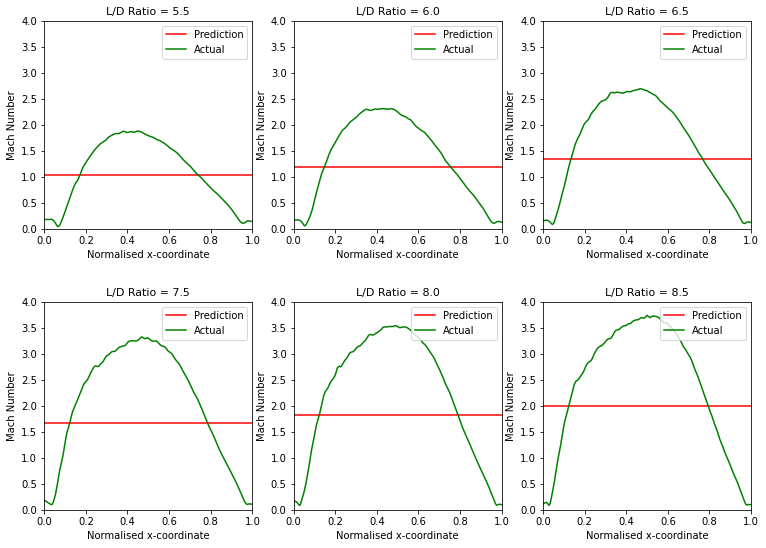

In [142]:
nrows=2
ncols = 3
fig3 = plt.figure()
fig, axes = plt.subplots(nrows, ncols)
fig.subplots_adjust(wspace=0.1, hspace=0.35)
fig.set_size_inches(13,9)
for j in range(nrows):
    for k in range(ncols):
        axes[j,k].plot(X_n_pred[:201],
                        pred[(3*j+k)*201:((3*j+k)+1)*201],
                        'r',
                        label='Prediction')
        axes[j,k].plot(X_n_pred[:201],
                        y_pred[(3*j+k)*201:((3*j+k)+1)*201],
                        'g', label='Actual')
        axes[j,k].set(xlabel="Normalised x-coordinate",
                    ylabel="Mach Number")
        axes[j,k].set_title('L/D Ratio = %.1f' %(X_pred[201*(3*j+k),1]),
                            fontsize=11)
        axes[j,k].legend(loc="upper right")
        axes[j,k].set_xlim((0,1))
        axes[j,k].set_ylim((0,4))
        axes[j,k].set_aspect(0.25)

fig = plt.gcf()
# fig.suptitle("Adam_HPT_hl_pred.png", fontsize=16)
# plt.tight_layout(pad=0.25, h_pad=1.25, w_pad=0.25, rect=None)
# plt.savefig('Adam_HPT_hl_norm_pred.png', dpi=500)
# plt.show(fig3)
plt.close(fig3)

In [72]:
print(pred.shape)

(1206, 1)


In [73]:
for i in range(int(X_pred.shape[0]/201)):
    max_val = get_max_APE(get_APE(pred[i*201:(i+1)*201],y_pred[i*201:(i+1)*201]))
    print("For L/D = %.1f, the MAPE is %f at x: %f" %(X_pred[i*201,1],
                                                      max_val[0]*100,
                                                      max_val[1]))

For L/D = 5.5, the MAPE is 7.233726 at x: 40.000000
For L/D = 6.0, the MAPE is 9.229818 at x: 47.000000
For L/D = 6.5, the MAPE is 7.039001 at x: 56.000000
For L/D = 7.5, the MAPE is 6.045688 at x: 159.000000
For L/D = 8.0, the MAPE is 4.691133 at x: 73.000000
For L/D = 8.5, the MAPE is 1.938715 at x: 70.000000


In [0]:
model = load_model('temp_models/SiameseModel3')
# print(model.summary())
# input_layer = model.get_layer('MaxVal_layer1').input
intermediate_layer = model.get_layer('IndVal_Final_layer').output
model_intermediate = Model(inputs=model.input, outputs=intermediate_layer)
intermediate_prediction=model_intermediate.predict(X_pred)

In [0]:
for i in range(int(pred.shape[0]/201)):
    plt.plot(X_n_pred[i*201:(i+1)*201], intermediate_prediction[i*201:(i+1)*201], 'r', label='Prediction')
    plt.plot(X_n_pred[i*201:(i+1)*201],y_pred_norm[i*201:(i+1)*201], 'g', label='Actual')
    plt.legend(loc='upper right')
    plt.title('L/D Ratio = %.1f' %(X_pred[i*201,1]))
    plt.show()
    plt.close